<a href="https://colab.research.google.com/github/2813/dls-homework/blob/main/%5Bhw%5Dsegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I2wUTT12p5bX3RCku_T_82aD4tkY9LVY" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов.

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>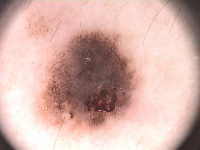</td><td>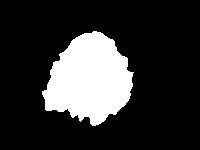</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

# если по ссылке слишком много запросов, датасет можно скачать с kaggle: https://www.kaggle.com/datasets/kanametov/ph2dataset

--2023-11-26 00:46:07--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.13.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.13.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2023-11-26 00:46:07--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 429 Too Many Requests
2023-11-26 00:46:08 ERROR 429: Too Many Requests.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/DLS/HOME6/

/content/drive/My Drive/DLS/HOME6


In [ ]:
get_ipython().system_raw("unzip archive.zip")

In [ ]:
!ls

archive.zip  PH2Dataset  unet_bce.pth


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

#for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
for root, dirs, files in os.walk(os.path.join(root, 'PH2_Dataset')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

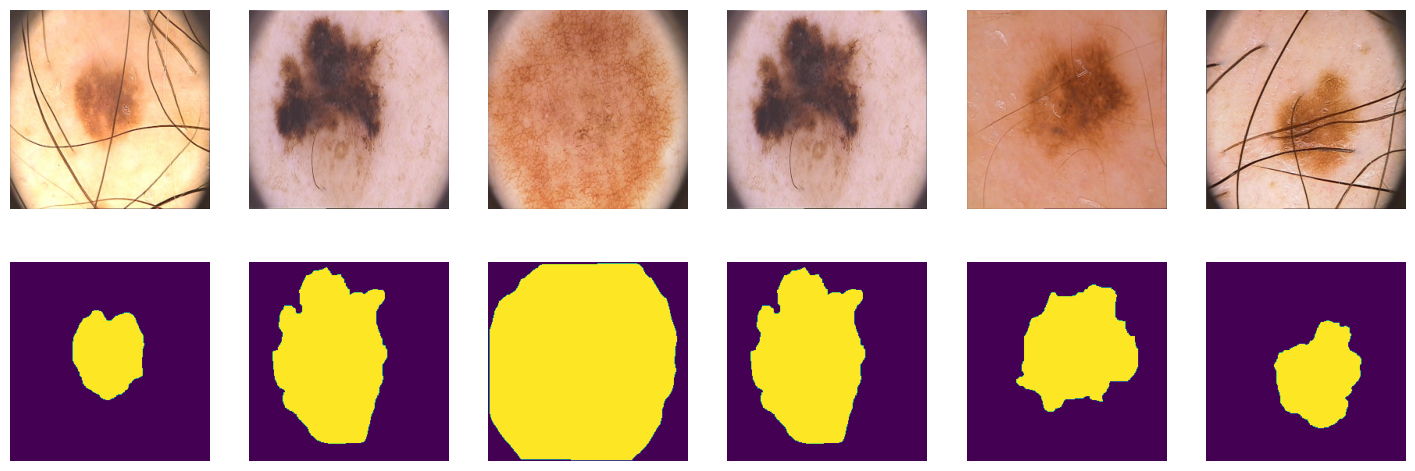

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    ind = np.random.randint(1,200)
    plt.imshow(X[ind])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[ind])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

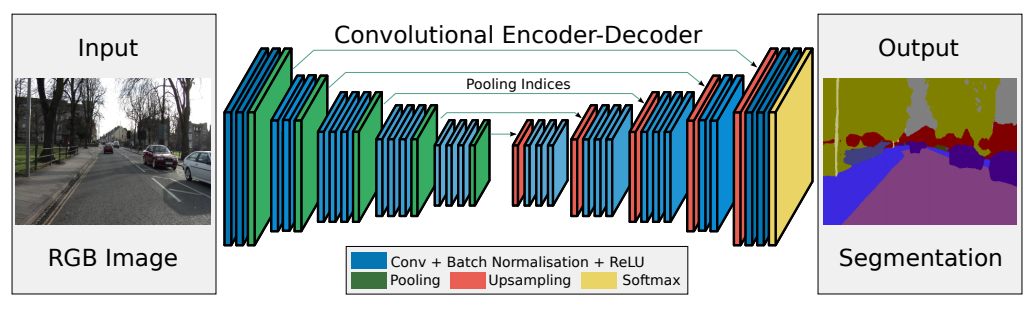

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,6)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True), #пишут, что inplace=true экономит память

            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.pool0 = nn.MaxPool2d(2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256,512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512,512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512,512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 1, 3, padding=1), # один канал на выходе. принадлежность маске или нет
            #nn.BatchNorm2d(256), # следующего слоя нет, не надо делать батчнорм.
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0, id0 = self.pool0(e0) #сохраняем индексы, чтобы их потом использовать с MaxUnpool2d

        e1 = self.enc_conv1(e0)
        e1, id1 = self.pool1(e1)

        e2 = self.enc_conv2(e1)
        e2, id2 = self.pool2(e2)

        e3 = self.enc_conv3(e2)
        e3, id3 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, id3))
        d1 = self.dec_conv1(self.upsample1(d0, id2))
        d2 = self.dec_conv2(self.upsample2(d1, id1))
        d3 = self.dec_conv3(self.upsample3(d2, id0)) # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  #
    #return iou

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    # TODO
    # please don't use nn.BCELoss. write it from scratch
    return torch.mean(torch.log(1 + torch.exp(-y_pred)) + y_pred*(1-y_real))


In [ ]:
# проверяем, что наша реализация bce совпадает с nn.BCELoss
output = torch.randn(3,3)
target = torch.eye(3)

sigm = nn.Sigmoid()
print(
    bce_loss(target, output),
    nn.BCELoss(reduction='mean')(sigm(output), target),
    sep='\n'
)

tensor(0.7631)
tensor(0.7631)


## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    train_loss=[]
    valid_loss=[]
    saved_score=[]
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        train_loss.append(avg_loss.item())
        saved_score.append(score_model(model, iou_pytorch, data_val))

        # show intermediate results
        model.eval()  # testing mode
        # нужен ли тут torch.no_grad?
        with torch.no_grad():
          Y_hat = model(X_val.to(device)).detach().cpu() # detach and put into cpu
          Y_hat = (Y_hat > 0.5).int() # чтобы график был не размытым
        v_loss = loss_fn(Y_val, Y_hat) # сохраняем лосс для эпохи на валидации
        valid_loss.append(v_loss.item())

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_val[k, 0], cmap='gray')
            plt.title('Ground Truth')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    return train_loss, valid_loss, saved_score

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        with torch.no_grad():
          Y_pred = model(X_batch.to(device))
        Y_pred = (torch.sigmoid(Y_pred)>0.5).int()
        scores += metric(Y_pred.to(device), Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
model = SegNet().to(device)

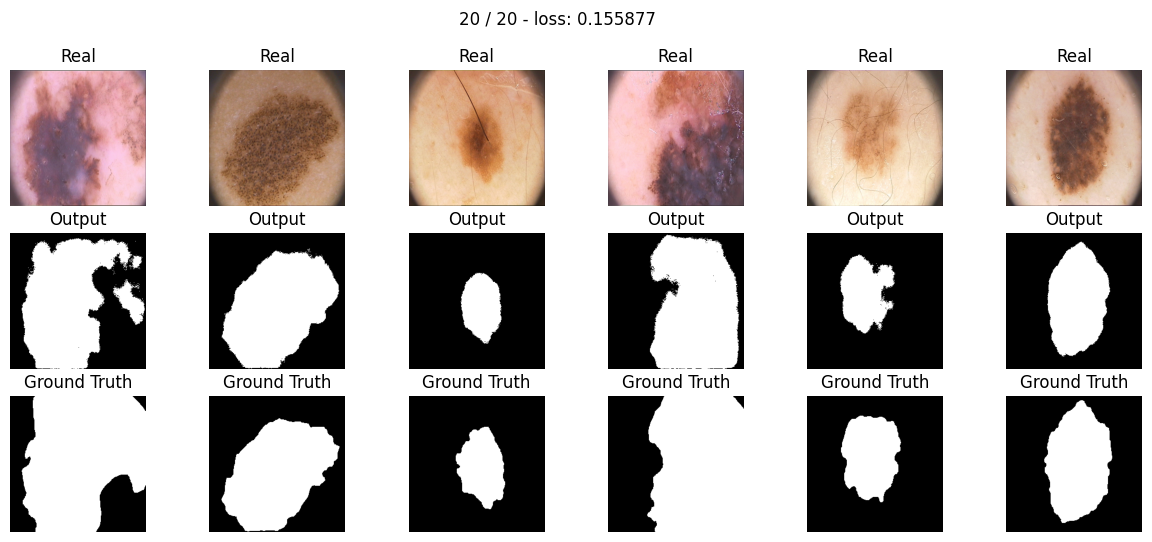

In [ ]:
max_epochs = 20
optim = torch.optim.AdamW(model.parameters(), lr=1e-4) # add optim
tloss, vloss, score = train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
torch.save(model, "/content/drive/My Drive/DLS/HOME6/seg_bce.pth" )

In [ ]:
score_model(model, iou_pytorch, data_val)

0.7199999809265136

In [ ]:
def show_loss(train_loss, valid_loss):
    plt.figure(figsize=(12, 8))
    plt.plot(train_loss, label="train")
    plt.plot(valid_loss, label="val")
    plt.title('Loss')
    plt.xlim([0, len(train_loss)-1])
    plt.grid(True)
    plt.legend()
    plt.show()


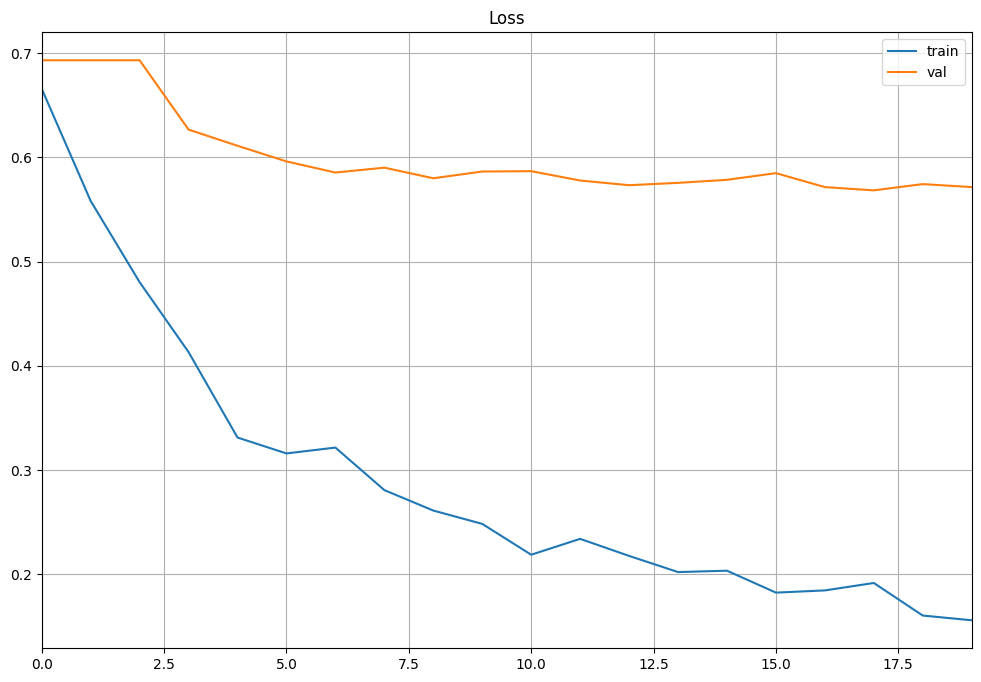

In [ ]:
show_loss(tloss, vloss)

Ответьте себе на вопрос: не переобучается ли моя модель?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла]

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    eps = 1e-8
    num = torch.sum(2*y_real*y_pred)
    den = torch.sum(y_real+y_pred)
    res = 1 - (num + eps)/(den + eps) # убрали коэф. 1/256**2 так как с ним лосс неадекватен, всегда 1
    return res.mean()

Проводим тестирование:

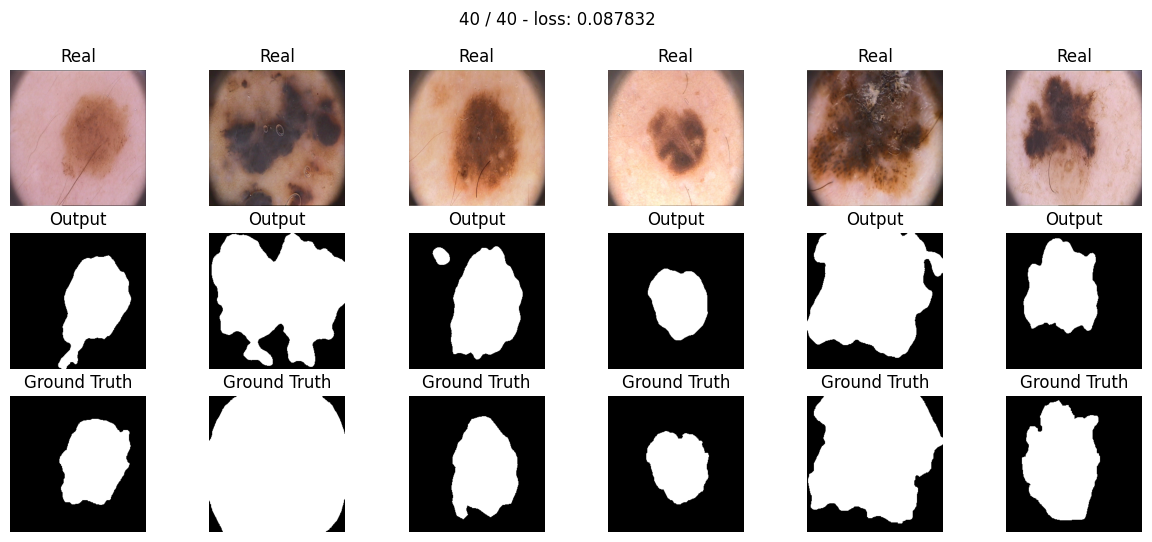

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 40
optimaizer = torch.optim.Adam(model_dice.parameters(), lr=1e-4) #, weight_decay=0.3)
train_loss_d, valid_loss_d, score_d = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

0.7040000200271607

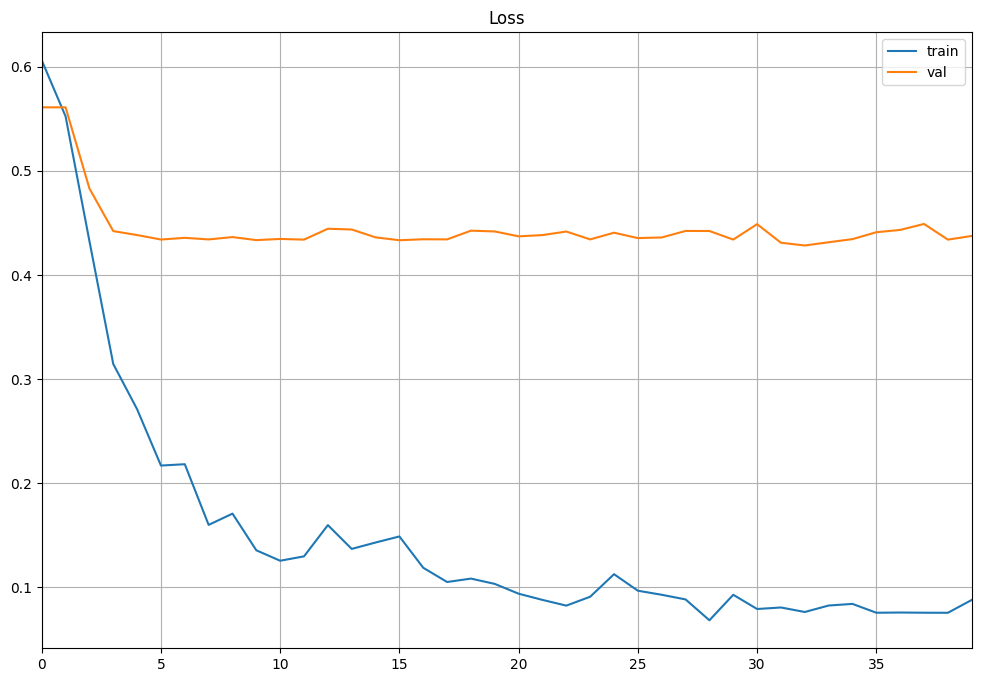

In [ ]:
show_loss(train_loss_d, valid_loss_d)

In [ ]:
torch.save(model_dice, "/content/drive/My Drive/DLS/HOME6/seg_dice.pth" )

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
# Реализуем фокал лосс из формулы выше, но, как выяснилось, с ней не стабильно происходит обучение
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred =  torch.sigmoid(y_pred)
    y_pred = torch.clamp(y_pred, 0+eps, 1-eps) # hint: torch.clamp
    pow = torch.pow((1-y_pred), gamma)
    bce = y_real*torch.log(y_pred) + (1-y_real) * torch.log(1-y_pred)
    your_loss =  torch.sum(-pow*bce)

    return your_loss


In [ ]:
# реализуем фокал по аналогии с ops.sigmoid_focal
def fcl_loss(y_real, y_pred, eps=1e-8, gamma=2):
  y_pred_sigm =  torch.sigmoid(y_pred)
  p_t = y_pred_sigm * y_real + (1 - y_pred_sigm) * (1 - y_real)
  bceloss = (y_pred - (y_real * y_pred) + torch.log(1 + torch.exp(-y_pred)))
  return (bceloss * ((1 - p_t) ** gamma)).mean()

In [ ]:
#проверяем, как работает наш focal
import torchvision
target = torch.randn(3,3)
output = torch.randn(3,3)
print(
    focal_loss(target, output), #приведенный в ноуте лосс дает отклоненения
    fcl_loss(target, output),   # а этот совпадает с выводом sigm_focal
    torchvision.ops.sigmoid_focal_loss(output, target, alpha=-1, reduction="mean"),
    #torchvision.ops.sigmoid_focal_loss(output, target, alpha=0.25, reduction="mean"),
    sep="\n"
)

tensor(1.5561)
tensor(0.6080)
tensor(0.6080)


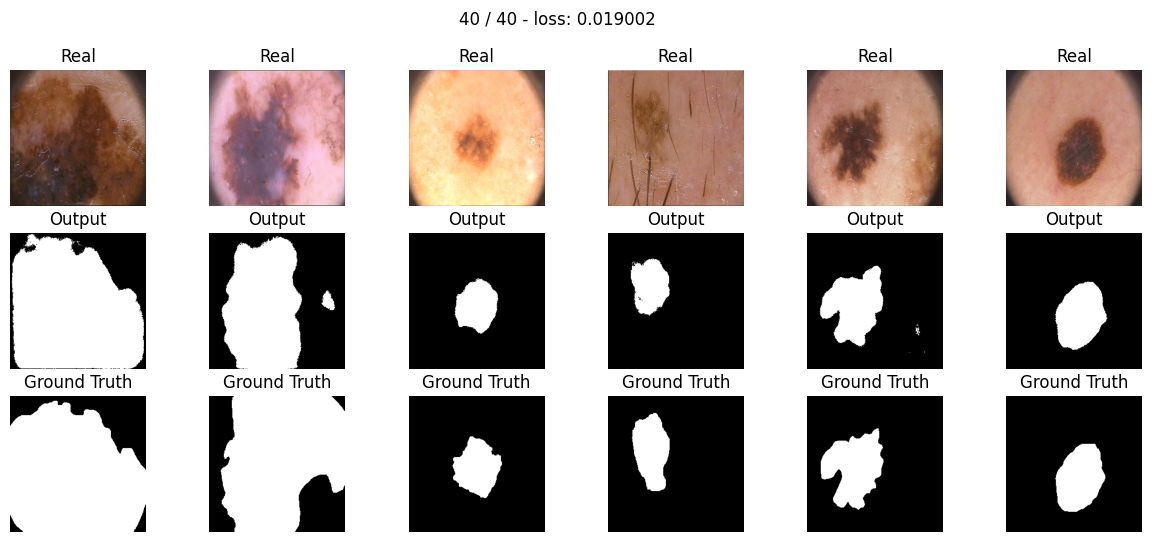

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 40
optimaizer = torch.optim.Adam(model_focal.parameters(), lr=1e-4)#, weight_decay=0.3)
train_loss_f, valid_loss_f, score_f = train(model_focal, optimaizer, fcl_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_focal, iou_pytorch, data_val)

0.7960000276565552

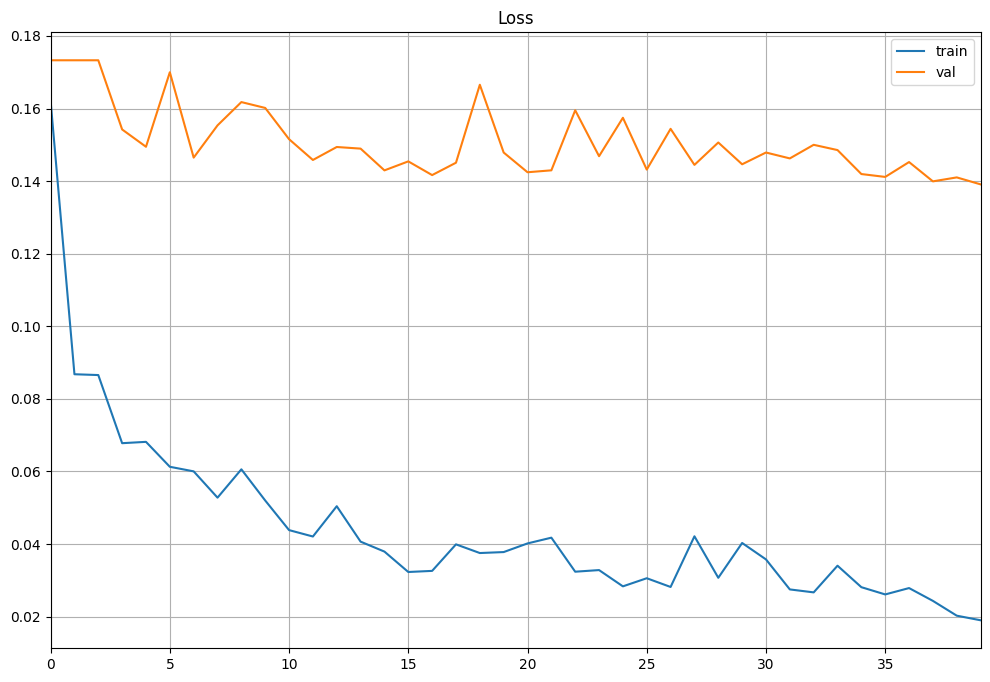

In [ ]:
show_loss(train_loss_f, valid_loss_f)

In [ ]:
torch.save(model_focal, "/content/drive/My Drive/DLS/HOME6/seg_focal.pth" )

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты?

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [ ]:
def lova_loss(y_real, y_pred):
    y_pred = y_pred.flatten()
    y_real = y_real.flatten()
    signs = 2 * y_real.float() - 1
    errors = (1 - y_pred * signs)
    errors_sorted, indices = torch.sort(errors, dim=0, descending=True)
    gt_sorted = y_real[indices.data]

    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    grad = 1. - intersection / union

    p = len(gt_sorted)
    grad[1:p] = grad[1:p] - grad[0:-1]

    loss = torch.dot(torch.relu(errors_sorted), grad)
    return loss

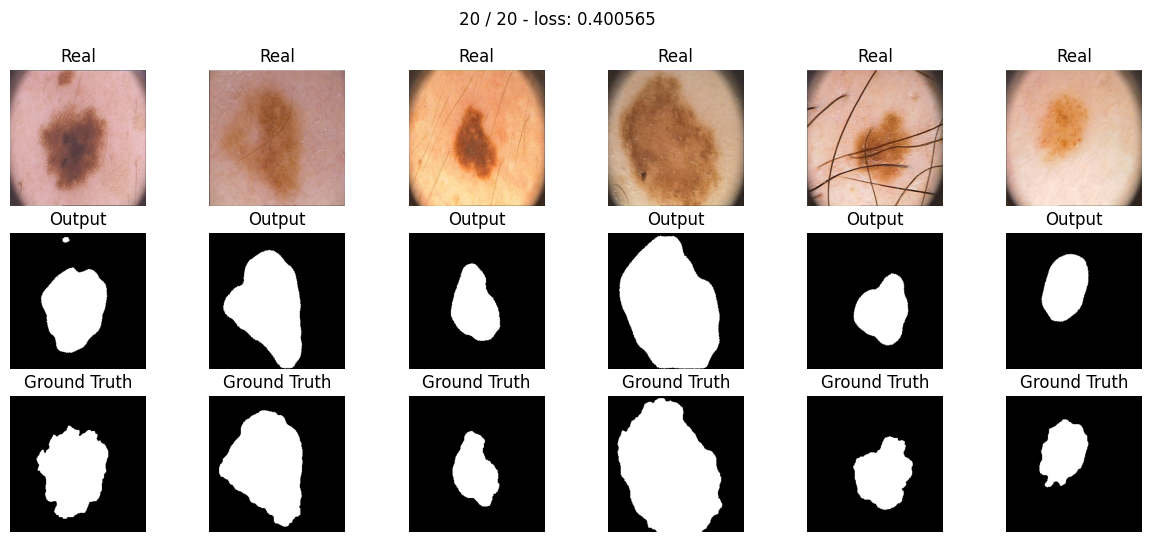

In [ ]:
seg_lova_model = SegNet().to(device)

max_epochs = 20
optimaizer = torch.optim.AdamW(seg_lova_model.parameters(), lr=1e-4)
train_loss_l, valid_loss_l, score_l = train(seg_lova_model, optimaizer, lova_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(seg_lova_model, iou_pytorch, data_val)

0.6980000257492065

In [ ]:
torch.save(seg_lova_model, "/content/drive/My Drive/DLS/HOME6/seg_lova.pth" )

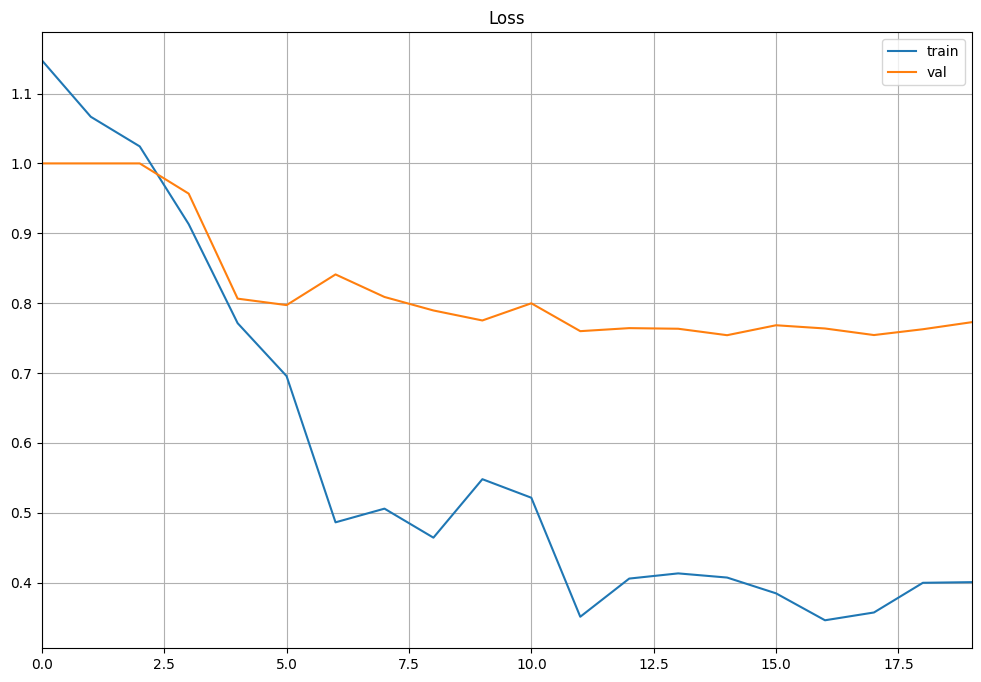

In [ ]:
show_loss(train_loss_l, valid_loss_l)

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

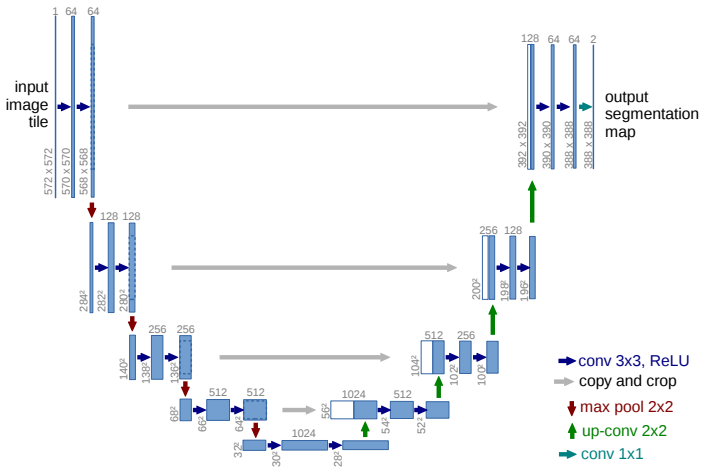

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
#Реализуем Unet не как в статье, а с nn.Upsample в качестве up-элемента.
# ибо в Unet2 нас просят upsample заменить на ConvTranspose2d (хотя в статье изначально up-conv)
from torchvision import transforms
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool0 = nn.MaxPool2d(2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2)  # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),

            nn.Conv2d(1024, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='nearest') # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512,256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest') # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest') # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.upsample3 = nn.Upsample(scale_factor=2, mode='nearest')  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 1, kernel_size=1)
        )

    def forward(self, x):

        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        up0 = self.upsample0(b)

          ## разного размера слои в энкодере и декодере на одном и том же уровне. См. картинку
        e3 = transforms.functional.resize(e3, size=up0.shape[2:], antialias=True) # antialias=True чтобы убрать ворнинг
          ## соединяем слои после энкодера и декодера
        d0 = self.dec_conv0(torch.cat((e3, up0), dim=1)) #skip connection

        up1 = self.upsample1(d0)
        e2 = transforms.functional.resize(e2, size=up1.shape[2:], antialias=True)
        d1 = self.dec_conv1(torch.cat((e2, up1), dim=1))

        up2 = self.upsample2(d1)
        e1 = transforms.functional.resize(e1, size=up2.shape[2:], antialias=True)
        d2 = self.dec_conv2(torch.cat((e1, up2), dim=1))

        up3 = self.upsample3(d2)
        e0 = transforms.functional.resize(e0, size=up3.shape[2:], antialias=True)
        d3 = self.dec_conv3(torch.cat((e0, up3), dim=1)) # no activation

        return d3

In [ ]:
unet_model = UNet().to(device)

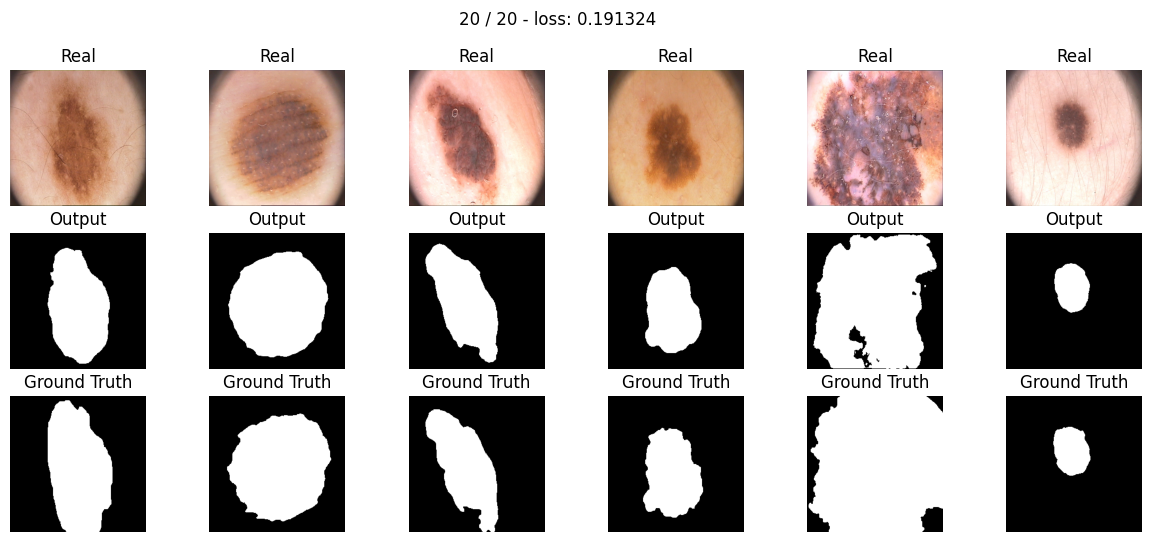

In [ ]:
optim = torch.optim.AdamW(unet_model.parameters(), lr=1e-4, weight_decay=0.3)
unet_tloss, unet_vloss, unet_score = train(unet_model, optim, bce_loss, 20, data_tr, data_val)

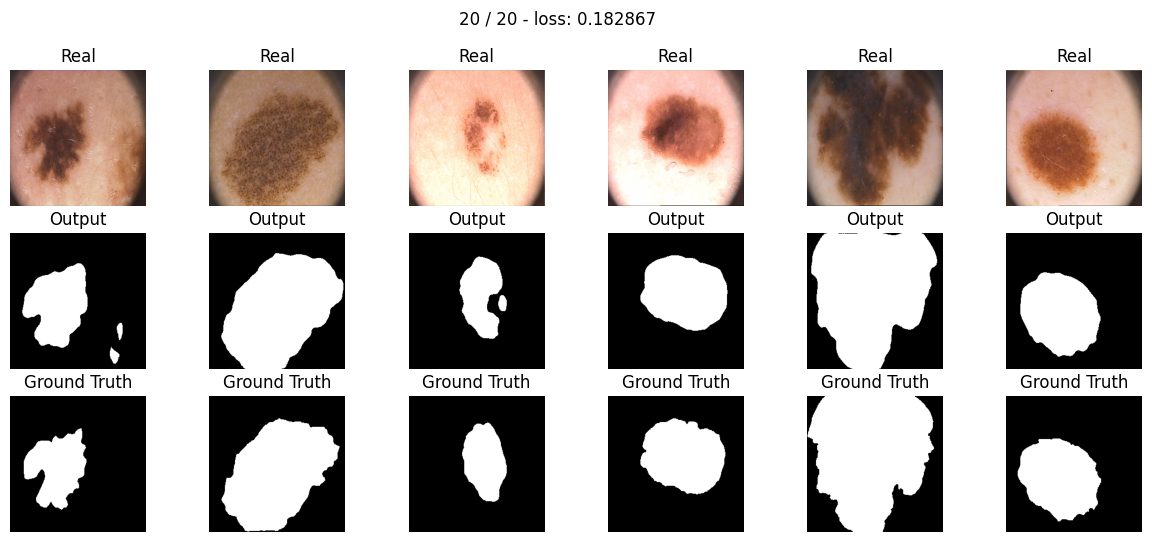

In [ ]:
unet_model = UNet().to(device)
optim = torch.optim.AdamW(unet_model.parameters(), lr=1e-4)
unet_tloss, unet_vloss, unet_score = train(unet_model, optim, dice_loss, 20, data_tr, data_val)

In [ ]:
torch.save(unet_model, "/content/drive/My Drive/DLS/HOME6/unet_dice.pth" )

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

0.7840000271797181

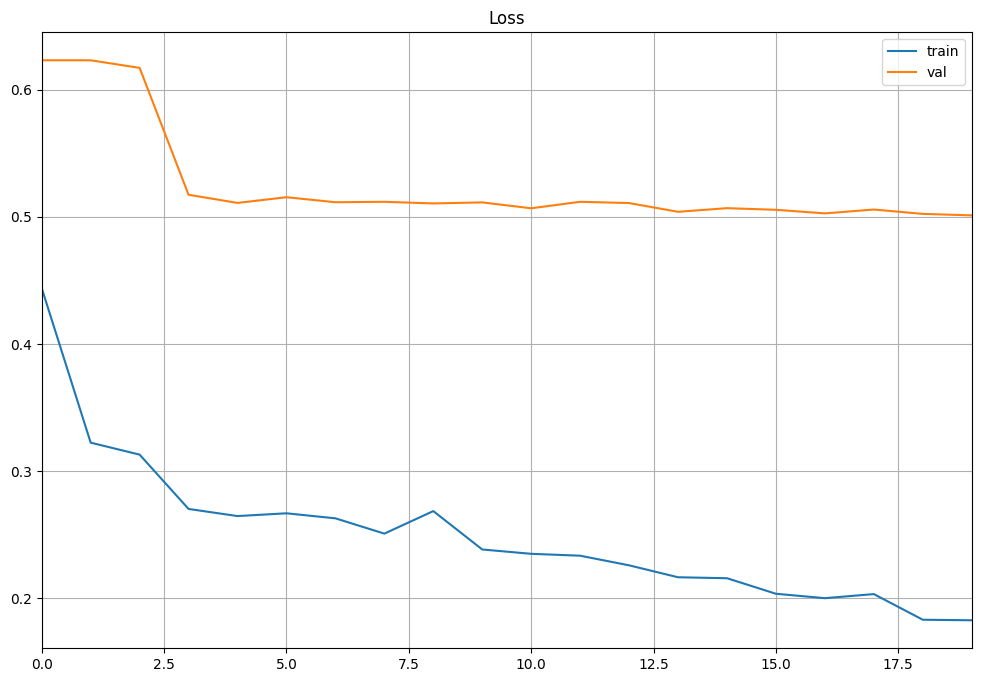

In [ ]:
show_loss(unet_tloss, unet_vloss)

In [ ]:
torch.save(unet_model, "/content/drive/My Drive/DLS/HOME6/unet_bce.pth" )

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
from torchvision import transforms

# тоже что Unet только вместо pool=Maxpool2d конволюшен со stride=2. размерность так же упадет в два раза
# вместо upsample используем ConvTranspose2d
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool0 = nn.Conv2d(64, 64, kernel_size=3, stride = 2, padding=1)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.Conv2d(128, 128, kernel_size=3, stride = 2, padding=1)  # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.Conv2d(256, 256, kernel_size=3, stride = 2, padding=1) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.Conv2d(512, 512, kernel_size=3, stride = 2, padding=1) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),

            nn.Conv2d(1024, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512,512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.upsample1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.upsample3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 1, kernel_size=1)
        )

    def forward(self, x):

        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        up0 = self.upsample0(b)
          ## разного размера слои в энкодере и декодере на одном и том же уровне. См. картинку
        e3 = transforms.functional.resize(e3, size=up0.shape[2:], antialias=True)
          ## соединяем слои после энкодера и декодера

        d0 = self.dec_conv0(torch.cat((e3, up0), dim=1)) #skip connection

        up1 = self.upsample1(d0)
        e2 = transforms.functional.resize(e2, size=up1.shape[2:], antialias=True)
        d1 = self.dec_conv1(torch.cat((e2, up1), dim=1))

        up2 = self.upsample2(d1)
        e1 = transforms.functional.resize(e1, size=up2.shape[2:], antialias=True)
        d2 = self.dec_conv2(torch.cat((e1, up2), dim=1))

        up3 = self.upsample3(d2)
        e0 = transforms.functional.resize(e0, size=up3.shape[2:], antialias=True)
        d3 = self.dec_conv3(torch.cat((e0, up3), dim=1)) # no activation

        return d3

In [ ]:
unet2_model = UNet2().to(device)


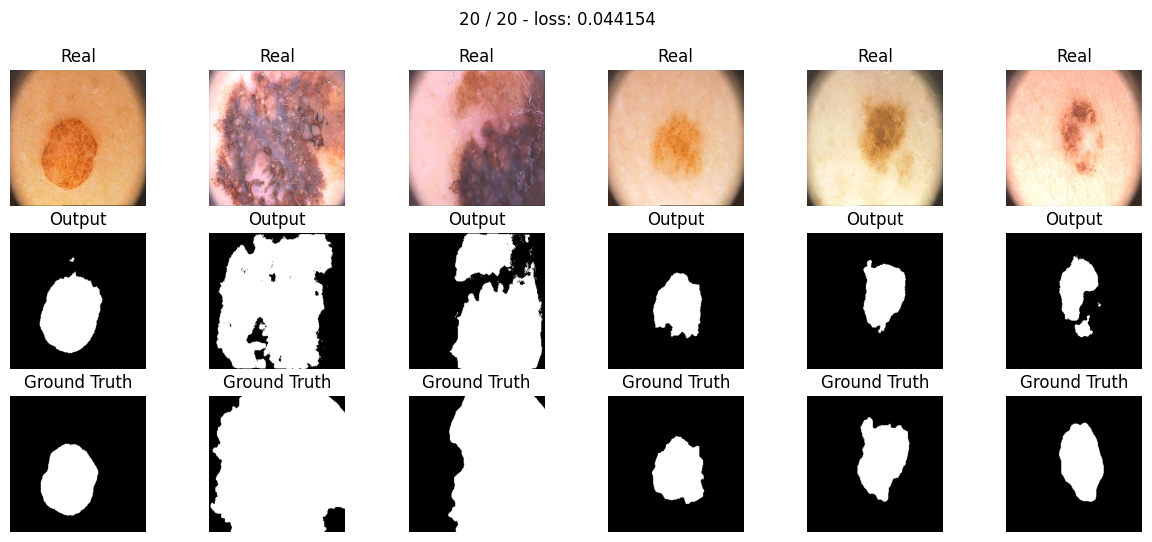

In [ ]:
opt = torch.optim.AdamW(unet2_model.parameters(), lr=1e-4)
u2_tloss, u2_vloss, u2_score = train(unet2_model, opt, fcl_loss, 20, data_tr, data_val)

In [ ]:
score_model(unet2_model, iou_pytorch, data_val)

0.7420000553131103

In [ ]:
torch.save(unet2_model, "/content/drive/My Drive/DLS/HOME6/unet2_focal.pth" )

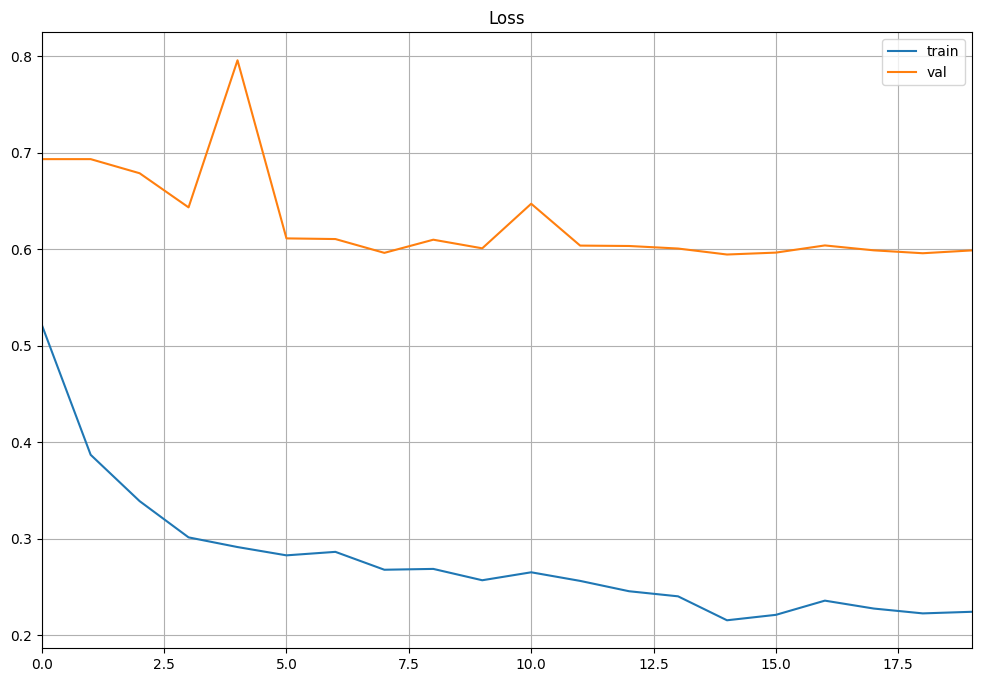

In [ ]:
show_loss(u2_tloss, u2_vloss)

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов):
Что мы сделали? Реализовали три архитектуры: Segnet, Unet, Unet2.

Реализовали 4 функции потерь: bce, dice, focal и lova

Получили 12 всевозможных вариантов модель-лосс. Обучали последовательно, поэтому не все варианты можно увидить в ноутбуке. Например, обучили сегнет с dice, записали модель в файл, поменяли лосс функцию и в этой же ячейке обучаем сегнет с другим лоссом.

Далее можно загрузить из файла предобученные модели и вызвать для них score_model на **тестовой** выборке (на отложенной выборке, не на трейне или валидации) и сравнить полученные scores.


|        |  bce  | dice | focal | lova |
|:------:|:-----:|:----:|:-----:|:----:|
| SetNet | 0.704 | 0.754| 0.784 | 0.728|
|  Unet  | 0.800 | 0.748| 0.732 | 0.788|
|  Unet2 | 0.754 | 0.668| 0.736 | 0.736|

In [ ]:
m = UNet2().to(device) # здесь получаем segnet c bce (аналогично для других комбинаций)
m = torch.load("/content/drive/My Drive/DLS/HOME6/unet2_focal.pth")
m.eval()
score_model(m,iou_pytorch, data_ts) # тестовая выборка. получаем score и фиксируем в таблицу

0.7360000014305115

Как видим нет мажорирующей ни модели, ни метрики, т.е. нет модели, которая была бы лучше всех остальных для ВСЕХ лоссов. Так же нет лосса, который бы давал лучший score для любой модели. Вероятно это связано с тем, что выборка довольно маленькая и присутствует элемент случайности, какие картики попадут в трейн. Некоторые пары картинок довольно не информативны. Там маска занимает почти всю площадь. Модели рисуют более точную маску, с более извилистыми границами чем эталон. Score на таких случаях проседает. Попадет ли такая картинка в трейн, валидацию или на тест влияет на финальный score модели. Пример картинки, о которой идет речь. 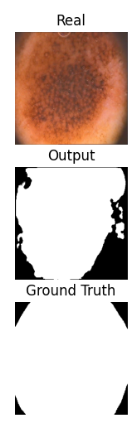